## Compare reference VMAF implementation and Pytorch version

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=200
import seaborn as sns
sns.set()

import torch
import torch.nn.functional as F

from vmaf_torch import VMAF, VMAF_C, yuv_to_tensor, tensor_to_yuv


np.set_printoptions(precision=5, suppress=True)
torch.set_printoptions(precision=5, sci_mode=False)

Check that elementary metrics values for frames are close (on one video) 

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# load reference and distorted yuv as tensors

yuv_path_ref = "/storage/data/NFLX_dataset_public/ref/BigBuckBunny_25fps.yuv"
yuv_path_dist = "/storage/data/NFLX_dataset_public/dis/BigBuckBunny_20_288_375.yuv"

width = 1920
height = 1080
num_frames = 50   # using only first frames to avoid CUDA out of memory errors

ref_t = yuv_to_tensor(yuv_path_ref, width, height, num_frames)
ref_t = ref_t.to(device)

dist_t = yuv_to_tensor(yuv_path_dist, width, height, num_frames)
dist_t = dist_t.to(device)

ref_t.shape, dist_t.shape

(torch.Size([50, 1, 1080, 1920]), torch.Size([50, 1, 1080, 1920]))

In [4]:
# initialize VMAF Pytorch version
#vmaf = VMAF(NEG=False, clip_score=True, temporal_pooling=True)
vmaf = VMAF(NEG=True, clip_score=True, temporal_pooling=True)
#vmaf = VMAF(NEG=False, clip_score=True, temporal_pooling=True, model_json_path='/home/kirill/Programs/preprocessing/vmaf_optimization/vmaf_torch/vmaf_v0.6.1.json')
vmaf = vmaf.to(device)

In [5]:
# initialize VMAF C version
vmaf_executable = 'vmaf'       # linux
#vmaf_executable = 'vmaf.exe'  # windows
#vmaf_executable = '/home/kirill/Programs/vmaf/libvmaf/build/tools/vmaf'  # built for float version
#vmaf_model_version = "default"
vmaf_model_version = "NEG"
#vmaf_model_version = 'float'
vmaf_c = VMAF_C(vmaf_executable=vmaf_executable, vmaf_model_version=vmaf_model_version)  # wrapper class for vmaf executable

In [6]:
# run VMAF Pytorch version
with torch.no_grad():
    df_torch = vmaf.table(ref_t, dist_t)
df_torch.head(10)

,Frame,integer_motion2,integer_motion,integer_adm2,integer_adm_scale0,integer_adm_scale1,integer_adm_scale2,integer_adm_scale3,integer_vif_scale0,integer_vif_scale1,integer_vif_scale2,integer_vif_scale3,vmaf
0,0,0.0,0.0,0.733147,0.815452,0.592996,0.621208,0.833636,0.249822,0.477729,0.605404,0.709635,20.482164
1,1,13.879902,13.879902,0.723379,0.811393,0.582982,0.604605,0.824964,0.251567,0.475548,0.5985,0.698282,30.665043
2,2,13.960742,13.960742,0.741392,0.815128,0.590992,0.628389,0.848631,0.268535,0.510236,0.642816,0.748341,36.229958
3,3,14.113519,14.113519,0.732279,0.817265,0.587556,0.614913,0.834399,0.265609,0.498773,0.625485,0.726695,33.62521
4,4,14.192772,14.192772,0.741415,0.820361,0.596716,0.628433,0.844797,0.274452,0.518283,0.650535,0.755257,36.778324
5,5,14.270576,14.270576,0.731785,0.817669,0.588605,0.617412,0.831423,0.270163,0.502652,0.628035,0.728778,33.731838
6,6,14.340849,14.340849,0.744372,0.819644,0.595178,0.637659,0.845503,0.27822,0.520782,0.652278,0.75731,37.499325
7,7,14.413815,14.413815,0.733421,0.821428,0.592923,0.617182,0.832876,0.271676,0.50263,0.627021,0.727279,34.03141
8,8,14.477407,14.482537,0.743311,0.822685,0.59958,0.630855,0.842939,0.280749,0.52222,0.652261,0.755255,37.288292
9,9,14.426366,14.477407,0.734868,0.821795,0.593616,0.622731,0.828985,0.275792,0.508032,0.632316,0.732261,34.508694


In [7]:
# run VMAF executable and read resulting csv table
df_C = vmaf_c.table_from_path(yuv_path_ref, yuv_path_dist, width, height, num_frames)
# rename some volumns so both tables have same column names
df_C = df_C.rename(columns={s:s.removesuffix('_egl_1') for s in df_C.columns}).drop(columns='Unnamed: 13') # for NEG version
df_C = df_C.rename(columns={s:'integer_'+s if 'integer_'not in s else s for s in df_C.columns if (s!='Frame') and (s!='vmaf')})         # for float version
df_C.head(10)

Executing: vmaf -r /storage/data/NFLX_dataset_public/ref/BigBuckBunny_25fps.yuv -d /storage/data/NFLX_dataset_public/dis/BigBuckBunny_20_288_375.yuv -w 1920 -h 1080 --frame_cnt 50 -p 420 -b 8 --threads 16 -q --csv -o vmaf_out.csv --model version=vmaf_v0.6.1neg
Reading: vmaf_out.csv


,Frame,integer_motion2,integer_motion,integer_adm2,integer_adm_scale0,integer_adm_scale1,integer_adm_scale2,integer_adm_scale3,integer_vif_scale0,integer_vif_scale1,integer_vif_scale2,integer_vif_scale3,vmaf
0,0,0.000000,0.000000,0.733143,0.815457,0.592989,0.621202,0.833627,0.249831,0.477737,0.605413,0.709755,20.486564
1,1,13.879942,13.879942,0.723376,0.811398,0.582978,0.604599,0.824955,0.251572,0.475575,0.598594,0.698217,30.662060
2,2,13.960780,13.960780,0.741389,0.815133,0.590986,0.628382,0.848623,0.268532,0.510247,0.642857,0.748334,36.231004
3,3,14.113557,14.113557,0.732276,0.817270,0.587551,0.614906,0.834390,0.265612,0.498787,0.625478,0.726741,33.626916
4,4,14.192812,14.192812,0.741412,0.820367,0.596710,0.628424,0.844789,0.274451,0.518294,0.650559,0.755295,36.780038
5,5,14.270615,14.270615,0.731782,0.817674,0.588597,0.617406,0.831415,0.270164,0.502621,0.628070,0.728756,33.731586
6,6,14.340888,14.340888,0.744369,0.819648,0.595174,0.637653,0.845493,0.278230,0.520792,0.652294,0.757339,37.499944
7,7,14.413856,14.413856,0.733417,0.821432,0.592917,0.617175,0.832866,0.271681,0.502635,0.627043,0.727336,34.034961
8,8,14.477447,14.482575,0.743307,0.822689,0.599574,0.630847,0.842929,0.280753,0.522235,0.652286,0.755301,37.289804
9,9,14.426404,14.477447,0.734865,0.821801,0.593610,0.622726,0.828976,0.275789,0.508051,0.632382,0.732316,34.511583


In [8]:
df_difference = df_torch-df_C
df_difference.head(10)

,Frame,integer_motion2,integer_motion,integer_adm2,integer_adm_scale0,integer_adm_scale1,integer_adm_scale2,integer_adm_scale3,integer_vif_scale0,integer_vif_scale1,integer_vif_scale2,integer_vif_scale3,vmaf
0,0,0.0,0.0,0.000004,-0.000005,0.000007,0.000006,0.000009,-0.000017,-0.000087,0.000014,-0.000023,0.001948
1,0,-0.00004,-0.00004,0.000003,-0.000005,0.000004,0.000006,0.000009,-0.000012,-0.000125,-0.000087,0.000125,0.00806
2,0,-0.000038,-0.000038,0.000003,-0.000005,0.000006,0.000007,0.000008,-0.000005,-0.00008,-0.00001,0.000104,0.006568
3,0,-0.000038,-0.000038,0.000003,-0.000005,0.000005,0.000007,0.000009,-0.000007,-0.000101,0.000017,0.000016,0.004008
4,0,-0.00004,-0.00004,0.000003,-0.000006,0.000006,0.000009,0.000008,-0.000003,-0.000101,-0.000015,0.000015,0.003047
5,0,-0.000039,-0.000039,0.000003,-0.000005,0.000008,0.000006,0.000008,-0.000013,-0.000086,-0.000038,0.000037,0.003426
6,0,-0.000039,-0.000039,0.000003,-0.000004,0.000004,0.000006,0.00001,-0.000023,-0.000116,-0.000001,0.000052,0.006362
7,0,-0.000041,-0.000041,0.000004,-0.000004,0.000006,0.000007,0.00001,-0.000028,-0.000132,-0.000046,-0.00005,0.00089
8,0,-0.00004,-0.000038,0.000004,-0.000004,0.000006,0.000008,0.00001,-0.000022,-0.000127,0.000022,-0.000024,0.002299
9,0,-0.000038,-0.00004,0.000003,-0.000006,0.000006,0.000005,0.000009,-0.000018,-0.000151,-0.000053,0.000005,0.002821


In [9]:
# compute average difference
df_difference.abs().mean()

Frame                 0.000000
integer_motion2       0.000037
integer_motion        0.000037
integer_adm2          0.000004
integer_adm_scale0    0.000005
integer_adm_scale1    0.000006
integer_adm_scale2    0.000007
integer_adm_scale3    0.000009
integer_vif_scale0    0.000024
integer_vif_scale1    0.000126
integer_vif_scale2    0.000052
integer_vif_scale3    0.000056
vmaf                  0.006114
dtype: float64

Check that VMAF values for videos are close on a dataset 

In [7]:
# to download Netflix public dataset see https://github.com/Netflix/vmaf/blob/master/resource/doc/datasets.md

dataset_name = 'NFLX_public'
yuv_fmt = 'yuv420p'
width = 1920
height = 1080

#ref_dir = '/storage/data/NFLX_dataset_public/ref'
ref_dir = ''
#dis_dir = '/storage/data/NFLX_dataset_public/dis'
dis_dir = ''


In [8]:
# dataset metadata from https://github.com/Netflix/vmaf/blob/master/resource/dataset/NFLX_dataset_public.py
ref_videos = [
 {'content_id': 0,
  'content_name': 'BigBuckBunny',
  'path': ref_dir + '/BigBuckBunny_25fps.yuv'},
 {'content_id': 1,
  'content_name': 'BirdsInCage',
  'path': ref_dir + '/BirdsInCage_30fps.yuv'},
 {'content_id': 2,
  'content_name': 'CrowdRun',
  'path': ref_dir + '/CrowdRun_25fps.yuv'},
 {'content_id': 3,
  'content_name': 'ElFuente1',
  'path': ref_dir + '/ElFuente1_30fps.yuv'},
 {'content_id': 4,
  'content_name': 'ElFuente2',
  'path': ref_dir + '/ElFuente2_30fps.yuv'},
 {'content_id': 5,
  'content_name': 'FoxBird',
  'path': ref_dir + '/FoxBird_25fps.yuv'},
 {'content_id': 6,
  'content_name': 'OldTownCross',
  'path': ref_dir + '/OldTownCross_25fps.yuv'},
 {'content_id': 7,
  'content_name': 'Seeking',
  'path': ref_dir + '/Seeking_25fps.yuv'},
 {'content_id': 8,
  'content_name': 'Tennis',
  'path': ref_dir + '/Tennis_24fps.yuv'}
]

dis_videos = [{'asset_id': 0,
  'content_id': 0,
  'dmos': 100.0,
  'path': ref_dir + '/BigBuckBunny_25fps.yuv',
 },
 {'asset_id': 1,
  'content_id': 1,
  'dmos': 100.0,
  'path': ref_dir + '/BirdsInCage_30fps.yuv',
 },
 {'asset_id': 2,
  'content_id': 2,
  'dmos': 100.0,
  'path': ref_dir + '/CrowdRun_25fps.yuv',
 },
 {'asset_id': 3,
  'content_id': 3,
  'dmos': 100.0,
  'path': ref_dir + '/ElFuente1_30fps.yuv',
 },
 {'asset_id': 4,
  'content_id': 4,
  'dmos': 100.0,
  'path': ref_dir + '/ElFuente2_30fps.yuv',
 },
 {'asset_id': 5,
  'content_id': 5,
  'dmos': 100.0,
  'path': ref_dir + '/FoxBird_25fps.yuv',
 },
 {'asset_id': 6,
  'content_id': 6,
  'dmos': 100.0,
  'path': ref_dir + '/OldTownCross_25fps.yuv',
 },
 {'asset_id': 7,
  'content_id': 7,
  'dmos': 100.0,
  'path': ref_dir + '/Seeking_25fps.yuv',
 },
 {'asset_id': 8,
  'content_id': 8,
  'dmos': 100.0,
  'path': ref_dir + '/Tennis_24fps.yuv',
 },
 {'asset_id': 9,
  'content_id': 0,
  'dmos': 22.5,
  'path': dis_dir + '/BigBuckBunny_20_288_375.yuv',
 },
 {'asset_id': 10,
  'content_id': 0,
  'dmos': 35.0,
  'path': dis_dir + '/BigBuckBunny_30_384_550.yuv',
 },
 {'asset_id': 11,
  'content_id': 0,
  'dmos': 49.166666666666664,
  'path': dis_dir + '/BigBuckBunny_40_384_750.yuv',
 },
 {'asset_id': 12,
  'content_id': 0,
  'dmos': 61.666666666666664,
  'path': dis_dir + '/BigBuckBunny_50_480_1050.yuv',
 },
 {'asset_id': 13,
  'content_id': 0,
  'dmos': 78.333333333333329,
  'path': dis_dir + '/BigBuckBunny_55_480_1750.yuv',
 },
 {'asset_id': 14,
  'content_id': 0,
  'dmos': 97.5,
  'path': dis_dir + '/BigBuckBunny_75_720_3050.yuv',
 },
 {'asset_id': 15,
  'content_id': 0,
  'dmos': 95.0,
  'path': dis_dir + '/BigBuckBunny_80_720_4250.yuv',
 },
 {'asset_id': 16,
  'content_id': 0,
  'dmos': 99.166666666666671,
  'path': dis_dir + '/BigBuckBunny_85_1080_3800.yuv',
 },
 {'asset_id': 17,
  'content_id': 0,
  'dmos': 103.33333333333333,
  'path': dis_dir + '/BigBuckBunny_90_1080_4300.yuv',
 },
 {'asset_id': 18,
  'content_id': 0,
  'dmos': 99.166666666666671,
  'path': dis_dir + '/BigBuckBunny_95_1080_5800.yuv',
 },
 {'asset_id': 19,
  'content_id': 1,
  'dmos': 38.333333333333336,
  'path': dis_dir + '/BirdsInCage_40_288_375.yuv',
 },
 {'asset_id': 20,
  'content_id': 1,
  'dmos': 40.0,
  'path': dis_dir + '/BirdsInCage_50_288_550.yuv',
 },
 {'asset_id': 21,
  'content_id': 1,
  'dmos': 52.5,
  'path': dis_dir + '/BirdsInCage_60_384_550.yuv',
 },
 {'asset_id': 22,
  'content_id': 1,
  'dmos': 55.0,
  'path': dis_dir + '/BirdsInCage_65_384_750.yuv',
 },
 {'asset_id': 23,
  'content_id': 1,
  'dmos': 70.0,
  'path': dis_dir + '/BirdsInCage_80_480_750.yuv',
 },
 {'asset_id': 24,
  'content_id': 1,
  'dmos': 92.5,
  'path': dis_dir + '/BirdsInCage_85_720_1050.yuv',
 },
 {'asset_id': 25,
  'content_id': 1,
  'dmos': 100.83333333333333,
  'path': dis_dir + '/BirdsInCage_90_1080_1800.yuv',
 },
 {'asset_id': 26,
  'content_id': 1,
  'dmos': 102.5,
  'path': dis_dir + '/BirdsInCage_95_1080_3000.yuv',
 },
 {'asset_id': 27,
  'content_id': 2,
  'dmos': 20.0,
  'path': dis_dir + '/CrowdRun_03_288_375.yuv',
 },
 {'asset_id': 28,
  'content_id': 2,
  'dmos': 40.0,
  'path': dis_dir + '/CrowdRun_40_480_2350.yuv',
 },
 {'asset_id': 29,
  'content_id': 2,
  'dmos': 58.333333333333336,
  'path': dis_dir + '/CrowdRun_50_1080_4300.yuv',
 },
 {'asset_id': 30,
  'content_id': 2,
  'dmos': 67.5,
  'path': dis_dir + '/CrowdRun_65_1080_5800.yuv',
 },
 {'asset_id': 31,
  'content_id': 2,
  'dmos': 81.666666666666671,
  'path': dis_dir + '/CrowdRun_75_1080_7500.yuv',
 },
 {'asset_id': 32,
  'content_id': 2,
  'dmos': 85.0,
  'path': dis_dir + '/CrowdRun_80_1080_10000.yuv',
 },
 {'asset_id': 33,
  'content_id': 2,
  'dmos': 94.166666666666671,
  'path': dis_dir + '/CrowdRun_90_1080_15000.yuv',
 },
 {'asset_id': 34,
  'content_id': 3,
  'dmos': 18.333333333333332,
  'path': dis_dir + '/ElFuente1_10_288_375.yuv',
 },
 {'asset_id': 35,
  'content_id': 3,
  'dmos': 29.166666666666668,
  'path': dis_dir + '/ElFuente1_25_384_750.yuv',
 },
 {'asset_id': 36,
  'content_id': 3,
  'dmos': 66.666666666666671,
  'path': dis_dir + '/ElFuente1_50_480_1750.yuv',
 },
 {'asset_id': 37,
  'content_id': 3,
  'dmos': 72.5,
  'path': dis_dir + '/ElFuente1_60_720_2350.yuv',
 },
 {'asset_id': 38,
  'content_id': 3,
  'dmos': 86.666666666666671,
  'path': dis_dir + '/ElFuente1_70_1080_4300.yuv',
 },
 {'asset_id': 39,
  'content_id': 3,
  'dmos': 95.0,
  'path': dis_dir + '/ElFuente1_85_1080_5800.yuv',
 },
 {'asset_id': 40,
  'content_id': 3,
  'dmos': 99.166666666666671,
  'path': dis_dir + '/ElFuente1_90_1080_7500.yuv',
 },
 {'asset_id': 41,
  'content_id': 4,
  'dmos': 25.0,
  'path': dis_dir + '/ElFuente2_05_288_375.yuv',
 },
 {'asset_id': 42,
  'content_id': 4,
  'dmos': 55.0,
  'path': dis_dir + '/ElFuente2_30_480_1750.yuv',
 },
 {'asset_id': 43,
  'content_id': 4,
  'dmos': 58.333333333333336,
  'path': dis_dir + '/ElFuente2_50_720_3050.yuv',
 },
 {'asset_id': 44,
  'content_id': 4,
  'dmos': 68.333333333333329,
  'path': dis_dir + '/ElFuente2_60_1080_4300.yuv',
 },
 {'asset_id': 45,
  'content_id': 4,
  'dmos': 75.833333333333329,
  'path': dis_dir + '/ElFuente2_65_720_4250.yuv',
 },
 {'asset_id': 46,
  'content_id': 4,
  'dmos': 82.5,
  'path': dis_dir + '/ElFuente2_70_1080_5800.yuv',
 },
 {'asset_id': 47,
  'content_id': 4,
  'dmos': 93.333333333333329,
  'path': dis_dir + '/ElFuente2_80_1080_10000.yuv',
 },
 {'asset_id': 48,
  'content_id': 4,
  'dmos': 96.666666666666671,
  'path': dis_dir + '/ElFuente2_85_1080_15000.yuv',
 },
 {'asset_id': 49,
  'content_id': 4,
  'dmos': 97.5,
  'path': dis_dir + '/ElFuente2_90_1080_20000.yuv',
 },
 {'asset_id': 50,
  'content_id': 5,
  'dmos': 34.166666666666664,
  'path': dis_dir + '/FoxBird_20_288_375.yuv',
 },
 {'asset_id': 51,
  'content_id': 5,
  'dmos': 60.0,
  'path': dis_dir + '/FoxBird_40_384_750.yuv',
 },
 {'asset_id': 52,
  'content_id': 5,
  'dmos': 64.166666666666671,
  'path': dis_dir + '/FoxBird_55_480_750.yuv',
 },
 {'asset_id': 53,
  'content_id': 5,
  'dmos': 83.333333333333329,
  'path': dis_dir + '/FoxBird_65_480_1750.yuv',
 },
 {'asset_id': 54,
  'content_id': 5,
  'dmos': 90.833333333333329,
  'path': dis_dir + '/FoxBird_80_1080_2300.yuv',
 },
 {'asset_id': 55,
  'content_id': 5,
  'dmos': 101.66666666666667,
  'path': dis_dir + '/FoxBird_95_1080_5800.yuv',
 },
 {'asset_id': 56,
  'content_id': 6,
  'dmos': 30.833333333333332,
  'path': dis_dir + '/OldTownCross_20_288_375.yuv',
 },
 {'asset_id': 57,
  'content_id': 6,
  'dmos': 45.0,
  'path': dis_dir + '/OldTownCross_45_384_750.yuv',
 },
 {'asset_id': 58,
  'content_id': 6,
  'dmos': 57.5,
  'path': dis_dir + '/OldTownCross_55_480_750.yuv',
 },
 {'asset_id': 59,
  'content_id': 6,
  'dmos': 75.0,
  'path': dis_dir + '/OldTownCross_60_480_1750.yuv',
 },
 {'asset_id': 60,
  'content_id': 6,
  'dmos': 99.166666666666671,
  'path': dis_dir + '/OldTownCross_80_720_2350.yuv',
 },
 {'asset_id': 61,
  'content_id': 6,
  'dmos': 99.166666666666671,
  'path': dis_dir + '/OldTownCross_85_720_2950.yuv',
 },
 {'asset_id': 62,
  'content_id': 6,
  'dmos': 109.16666666666667,
  'path': dis_dir + '/OldTownCross_90_1080_4300.yuv',
 },
 {'asset_id': 63,
  'content_id': 7,
  'dmos': 19.166666666666668,
  'path': dis_dir + '/Seeking_10_288_375.yuv',
 },
 {'asset_id': 64,
  'content_id': 7,
  'dmos': 41.666666666666664,
  'path': dis_dir + '/Seeking_30_480_1050.yuv',
 },
 {'asset_id': 65,
  'content_id': 7,
  'dmos': 50.833333333333336,
  'path': dis_dir + '/Seeking_45_480_1750.yuv',
 },
 {'asset_id': 66,
  'content_id': 7,
  'dmos': 66.666666666666671,
  'path': dis_dir + '/Seeking_50_720_2350.yuv',
 },
 {'asset_id': 67,
  'content_id': 7,
  'dmos': 75.833333333333329,
  'path': dis_dir + '/Seeking_60_720_3050.yuv',
 },
 {'asset_id': 68,
  'content_id': 7,
  'dmos': 80.833333333333329,
  'path': dis_dir + '/Seeking_65_1080_4300.yuv',
 },
 {'asset_id': 69,
  'content_id': 7,
  'dmos': 91.666666666666671,
  'path': dis_dir + '/Seeking_75_1080_5800.yuv',
 },
 {'asset_id': 70,
  'content_id': 7,
  'dmos': 90.0,
  'path': dis_dir + '/Seeking_85_1080_7500.yuv',
 },
 {'asset_id': 71,
  'content_id': 7,
  'dmos': 91.666666666666671,
  'path': dis_dir + '/Seeking_90_1080_15000.yuv',
 },
 {'asset_id': 72,
  'content_id': 7,
  'dmos': 96.666666666666671,
  'path': dis_dir + '/Seeking_95_1080_20000.yuv',
 },
 {'asset_id': 73,
  'content_id': 8,
  'dmos': 33.333333333333336,
  'path': dis_dir + '/Tennis_20_288_375.yuv',
 },
 {'asset_id': 74,
  'content_id': 8,
  'dmos': 50.0,
  'path': dis_dir + '/Tennis_40_384_750.yuv',
 },
 {'asset_id': 75,
  'content_id': 8,
  'dmos': 71.666666666666671,
  'path': dis_dir + '/Tennis_60_480_1050.yuv',
 },
 {'asset_id': 76,
  'content_id': 8,
  'dmos': 68.333333333333329,
  'path': dis_dir + '/Tennis_70_480_1750.yuv',
 },
 {'asset_id': 77,
  'content_id': 8,
  'dmos': 94.166666666666671,
  'path': dis_dir + '/Tennis_80_720_3050.yuv',
 },
 {'asset_id': 78,
  'content_id': 8,
  'dmos': 99.166666666666671,
  'path': dis_dir + '/Tennis_90_1080_4300.yuv',
 }]


In [12]:
num_frames = 50   # using only first frames to avoid CUDA out of memory errors

c_vmaf_scores = []
torch_vmaf_scores = []

feature_names = ['integer_motion2', 'integer_motion', 'integer_adm2',
'integer_adm_scale0', 'integer_adm_scale1', 'integer_adm_scale2',
'integer_adm_scale3', 'integer_vif_scale0', 'integer_vif_scale1',
'integer_vif_scale2', 'integer_vif_scale3']

c_features = {f_n:[] for f_n in feature_names}
torch_features = {f_n:[] for f_n in feature_names}

for vid in dis_videos:
    yuv_path_dist = vid['path']
    yuv_path_ref = [d['path'] for d in ref_videos if d['content_id']==vid['content_id']][0]
    
    df_C = vmaf_c.table_from_path(yuv_path_ref, yuv_path_dist, width, height, num_frames)
    df_C = df_C.rename(columns={s:s.removesuffix('_egl_1') for s in df_C.columns}).drop(columns='Unnamed: 13') # for NEG version
    df_C = df_C.rename(columns={s:'integer_'+s if 'integer_'not in s else s for s in df_C.columns if (s!='Frame') and (s!='vmaf')}) # for float version
    c_score = df_C['vmaf'].mean()
    c_vmaf_scores.append(c_score)
    
    ref_t = yuv_to_tensor(yuv_path_ref, width, height, num_frames)
    ref_t = ref_t.to(device)
    dist_t = yuv_to_tensor(yuv_path_dist, width, height, num_frames)
    dist_t = dist_t.to(device)
    with torch.no_grad():
        #torch_score = vmaf(ref_t, dist_t).item()
        df_torch = vmaf.table(ref_t, dist_t)
    torch_score = df_torch['vmaf'].mean()
    torch_vmaf_scores.append(torch_score)
    
    for f_n in feature_names:
        c_features[f_n].extend(df_C[f_n].to_list())
        torch_features[f_n].extend(df_torch[f_n].to_list())

Executing: vmaf -r /storage/data/NFLX_dataset_public/ref/BigBuckBunny_25fps.yuv -d /storage/data/NFLX_dataset_public/ref/BigBuckBunny_25fps.yuv -w 1920 -h 1080 --frame_cnt 50 -p 420 -b 8 --threads 16 -q --csv -o vmaf_out.csv --model version=vmaf_v0.6.1neg
Reading: vmaf_out.csv
Executing: vmaf -r /storage/data/NFLX_dataset_public/ref/BirdsInCage_30fps.yuv -d /storage/data/NFLX_dataset_public/ref/BirdsInCage_30fps.yuv -w 1920 -h 1080 --frame_cnt 50 -p 420 -b 8 --threads 16 -q --csv -o vmaf_out.csv --model version=vmaf_v0.6.1neg
Reading: vmaf_out.csv
Executing: vmaf -r /storage/data/NFLX_dataset_public/ref/CrowdRun_25fps.yuv -d /storage/data/NFLX_dataset_public/ref/CrowdRun_25fps.yuv -w 1920 -h 1080 --frame_cnt 50 -p 420 -b 8 --threads 16 -q --csv -o vmaf_out.csv --model version=vmaf_v0.6.1neg
Reading: vmaf_out.csv
Executing: vmaf -r /storage/data/NFLX_dataset_public/ref/ElFuente1_30fps.yuv -d /storage/data/NFLX_dataset_public/ref/ElFuente1_30fps.yuv -w 1920 -h 1080 --frame_cnt 50 -p 420 

In [13]:
c_scores = np.array(c_vmaf_scores)
torch_scores = np.array(torch_vmaf_scores)

print(c_scores)
print(torch_scores)

[99.94851 98.25404 99.9485  99.9485  99.9485  98.66652 99.9485  99.94851
 99.9485  37.93097 52.31515 58.51458 69.99039 78.80627 91.31617 94.83684
 98.15884 99.21542 99.68861 46.82502 48.26073 60.91077 61.97605 71.86413
 82.19528 89.70702 90.84527  9.26158 44.26249 65.18197 73.69296 80.43152
 86.76027 93.35361 18.47426 33.81725 58.39891 69.13877 85.29706 91.82919
 96.28498  8.06128 26.68968 37.17405 42.33608 44.62311 51.14438 68.42753
 81.99043 90.51079 22.83601 46.11848 55.27782 69.05773 88.5261  95.66218
 23.67087 43.76641 55.64996 61.86097 78.71694 79.59138 90.71434 14.59693
 36.85754 48.0325  56.8378  63.68833 73.31384 81.05284 87.18227 97.36892
 98.77962 46.87485 65.16654 75.46719 82.0137  90.56563 95.55677]
[99.94855 98.25633 99.94857 99.94854 99.94856 98.66815 99.94856 99.94856
 99.94855 37.93709 52.3207  58.52073 69.99791 78.81784 91.33008 94.85654
 98.16888 99.22046 99.68879 46.89004 48.34408 61.00409 62.08971 71.9705
 82.3106  89.83721 90.99867  9.26858 44.28605 65.20677 73.71

In [98]:
#c_scores = np.array([99.94856, 98.25662, 99.94856, 99.94855, 99.94857, 98.66826, 99.94856, 99.94857,
#            99.94855, 38.77267, 53.45405, 59.57528, 71.26628, 79.80366, 92.59078, 95.89494,
#            99.36421, 99.64995, 99.72615, 47.8713 , 49.20007, 61.95285, 62.95595, 73.04774,
#            83.67003, 92.03811, 93.10625,  9.50615, 45.24235, 67.25528, 75.8502 , 82.62579,
#            88.94848, 95.46937, 18.96033, 34.78473, 59.81088, 71.02117, 87.90463, 94.42793,
#            98.31813,  8.17311, 27.51911, 38.36571, 43.87356, 45.95208, 52.97681, 70.6065,
#            84.31544, 92.40967, 23.62585, 47.11207, 56.70465, 69.9516 , 90.85483, 96.77523,
#            24.15121, 44.36051, 56.5914 , 62.48474, 79.74344, 80.52022, 93.08052, 14.99169,
#            38.1423 , 49.40092, 58.76257, 65.61184, 76.02255, 83.90921, 90.03208, 98.87703,
#            99.5548 , 48.70014, 66.91183, 77.35461, 83.50241, 92.32154, 97.5599 ,])

#torch_scores = np.array([99.94855, 98.25633, 99.94857, 99.94852, 99.94856, 98.6682 , 99.94856, 99.94858,
#                99.94855, 38.76918, 53.44974, 59.57076, 71.26163, 79.79903, 92.58531, 95.89039,
#                99.36157, 99.64983, 99.72594, 47.86439, 49.19118, 61.94929, 62.95972, 73.03864,
#                83.66441, 92.03106, 93.10261,  9.50634, 45.24839, 67.2621 , 75.85646, 82.63385,
#                88.95419, 95.47536, 18.96242, 34.78791, 59.81357, 71.02469, 87.90725, 94.43022,
#                98.32023,  8.17409, 27.51804, 38.3643 , 43.8732 , 45.95019, 52.97358, 70.60147,
#                84.30681, 92.40347, 23.62639, 47.1101 , 56.70267, 69.94661, 90.8589 , 96.77441,
#                24.17047, 44.3832 , 56.61804, 62.50987, 79.77009, 80.54612, 93.10773, 14.99149,
#                38.14014, 49.39861, 58.75997, 65.6092 , 76.01957, 83.90655, 90.02888, 98.87593,
#                99.55444, 48.72449, 66.93543, 77.37795, 83.52314, 92.34312, 97.56931,])

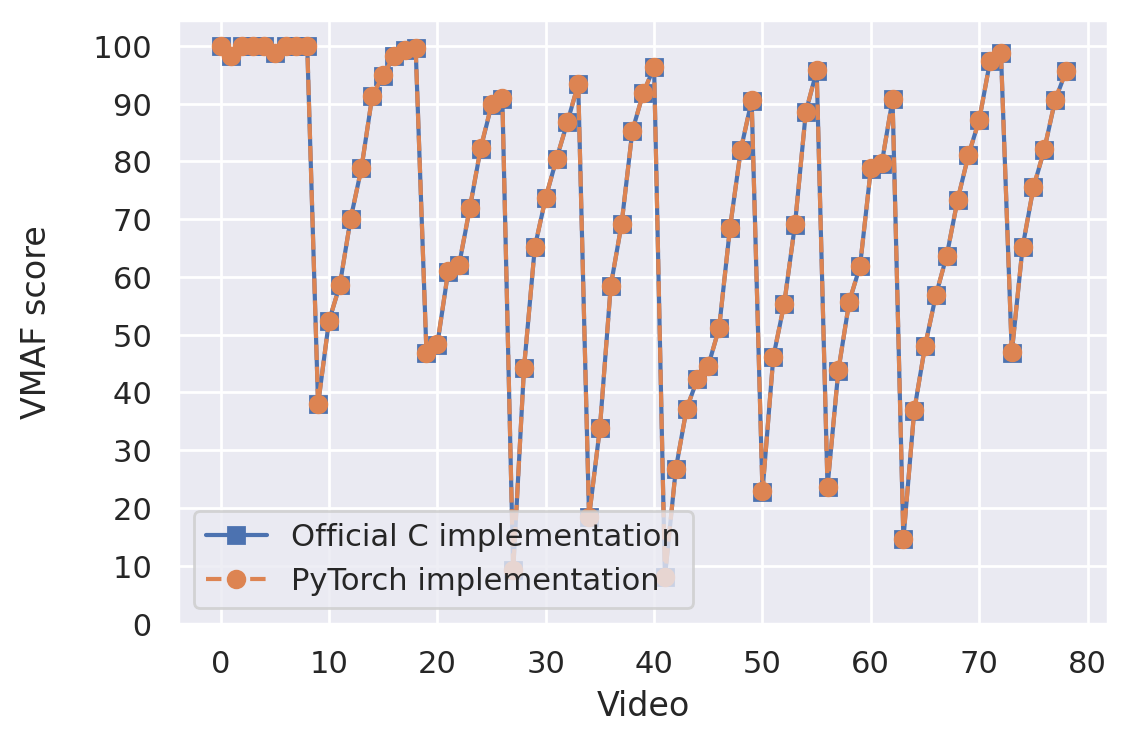

In [14]:
import os
#vid_names = [os.path.splitext(os.path.basename(x['path']))[0] for x in dis_videos]
plt.figure(figsize=(6,4))
#fig = plt.figure()
#ax = fig.add_subplot(111)
plt.plot(np.arange(79), c_scores, 's-', label='Official C implementation')
plt.plot(np.arange(79), torch_scores, 'o--', label='PyTorch implementation')
plt.xlabel('Video')
#plt.xticks(np.arange(0,81,10), minor=True)
#plt.xticks(np.arange(0,79), vid_names, rotation=270, fontsize=3)

#ax.set_xticks(np.arange(0,79), vid_names, rotation=270, fontsize=3)
#ax.set_xticks(np.arange(0,81,10), minor = True)
#ax.set_yticks(np.arange(0,101,20))
#ax.set_yticks(np.arange(0,101,10), minor = True)


plt.ylabel('VMAF score')
plt.yticks(np.arange(0,101, 10), labels=[str(x).rjust(6, ' ') for x in np.arange(0,101, 10)])  # make both plots the same size
#plt.grid(which='major', alpha=0.5)
#plt.grid(which='minor', linestyle='--', alpha=0.5)
#plt.grid(linestyle='--', alpha=0.5)

plt.legend(loc=3)


#sns.lineplot(x=np.arange(79), y=c_scores, label='Official C implementation', marker='s')
#sns.lineplot(x=np.arange(79), y=torch_scores, label='PyTorch implementation', marker='.', linestyle='dashed')

Text(0, 0.5, 'Official C implementation score')

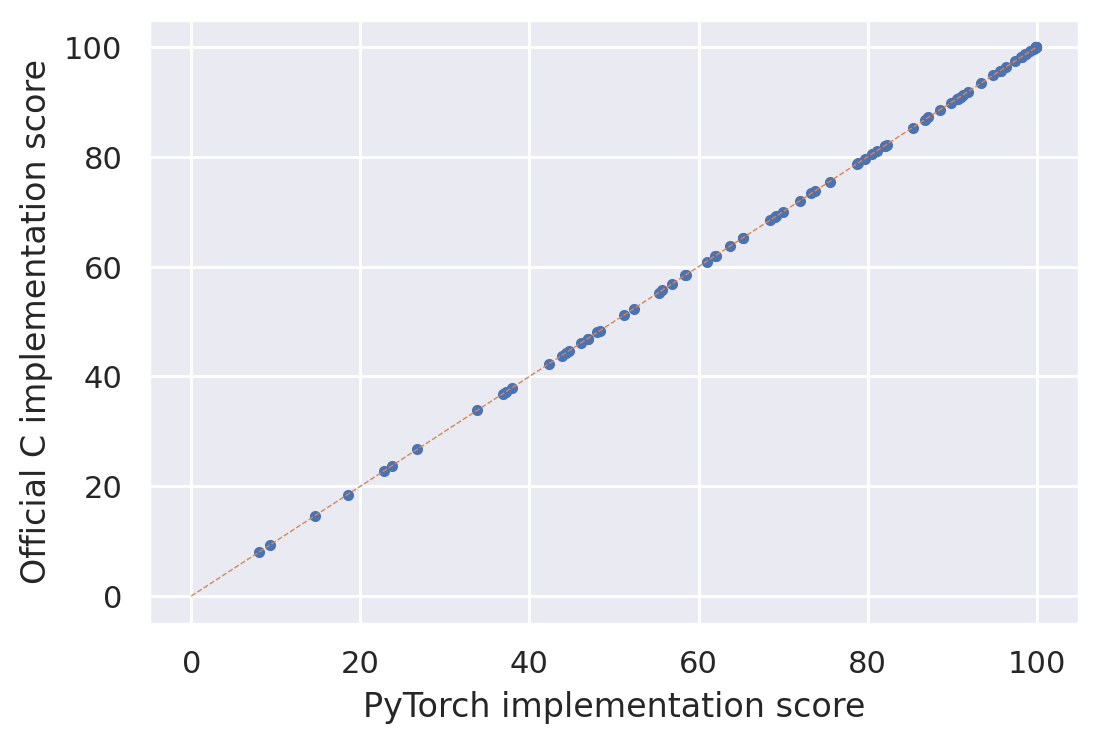

In [15]:
plt.plot(torch_scores, c_scores, 'o',  markersize=3)
plt.plot(np.arange(101), np.arange(101), '--', linewidth=0.5,)
#plt.plot(np.arange(79), torch_scores, 'o--', label='PyTorch implementation')
plt.xlabel('PyTorch implementation score')
#plt.xticks(np.arange(0,81,10), minor=True)
#plt.xticks(np.arange(0,79), vid_names, rotation=270, fontsize=3)

#ax.set_xticks(np.arange(0,79), vid_names, rotation=270, fontsize=3)
#ax.set_xticks(np.arange(0,81,10), minor = True)
#ax.set_yticks(np.arange(0,101,20))
#ax.set_yticks(np.arange(0,101,10), minor = True)


plt.ylabel('Official C implementation score')
#plt.yticks(np.arange(0,101, 10))
#plt.grid(which='major', alpha=0.5)
#plt.grid(which='minor', linestyle='--', alpha=0.5)
#plt.grid(linestyle='--', alpha=0.5)

#plt.legend()

In [16]:
dif = np.abs(torch_scores - c_scores)
dif

array([0.00004, 0.00228, 0.00007, 0.00005, 0.00006, 0.00162, 0.00006,
       0.00005, 0.00005, 0.00611, 0.00554, 0.00616, 0.00753, 0.01157,
       0.01391, 0.0197 , 0.01004, 0.00505, 0.00018, 0.06502, 0.08334,
       0.09332, 0.11365, 0.10637, 0.11532, 0.13019, 0.1534 , 0.007  ,
       0.02356, 0.0248 , 0.02514, 0.02718, 0.02619, 0.02903, 0.01061,
       0.01456, 0.01585, 0.01689, 0.01841, 0.02067, 0.02304, 0.00329,
       0.00841, 0.00971, 0.00987, 0.01139, 0.01019, 0.01468, 0.01884,
       0.02594, 0.01238, 0.01652, 0.01842, 0.03334, 0.0421 , 0.0698 ,
       0.03097, 0.03546, 0.03932, 0.03778, 0.04109, 0.04032, 0.04231,
       0.00769, 0.00988, 0.00713, 0.00752, 0.00553, 0.00597, 0.00455,
       0.0046 , 0.0044 , 0.00286, 0.05618, 0.05329, 0.05615, 0.06836,
       0.08147, 0.08557])

Text(0, 0.5, 'Absolute difference in VMAF scores')

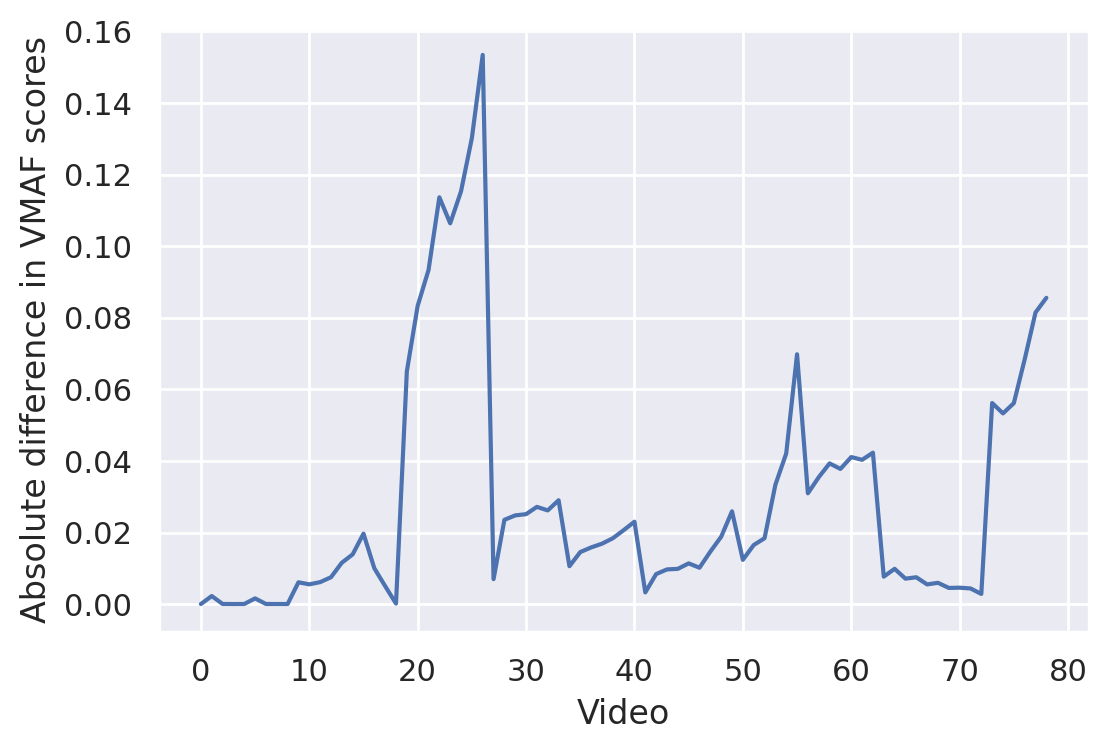

In [17]:
#plt.figure(figsize=(6,4))
plt.plot(np.arange(79), dif)
plt.xlabel('Video')
#plt.xticks(np.arange(0,79), vid_names, rotation=270, fontsize=3)
plt.ylabel('Absolute difference in VMAF scores')
#plt.grid(linestyle='--', alpha=0.5)

In [18]:
dif.mean(), dif.std(), dif.min(), dif.max()

(0.028695091155596257,
 0.03354241567283204,
 4.0069863274538875e-05,
 0.1534009942968737)

In [ ]:
dif.mean(), dif.std(), dif.min(), dif.max()

(0.024297265485812715,
 0.03458859536336538,
 2.0011582037682274e-05,
 0.15316021060546348)

In [ ]:
dif.mean(), dif.std(), dif.min(), dif.max()

(0.006341514665099452,
 0.007872519084080164,
 8.701367164576368e-07,
 0.0272055937206801)

In [19]:
for f_n in feature_names:
    f_dif = np.abs(np.array(c_features[f_n]) - np.array(torch_features[f_n]))
    print(f_n, f_dif.mean())

integer_motion2 2.10227016120057e-05
integer_motion 2.0914144144141918e-05
integer_adm2 4.8669817555103985e-06
integer_adm_scale0 7.710024167796103e-06
integer_adm_scale1 6.693479320188694e-06
integer_adm_scale2 8.422270798984472e-06
integer_adm_scale3 9.341695651285138e-06
integer_vif_scale0 4.5779922209812425e-05
integer_vif_scale1 0.00011959798216119601
integer_vif_scale2 0.0001479009191428541
integer_vif_scale3 0.00032079475716119757


In [ ]:
for f_n in feature_names:
    f_dif = np.abs(np.array(c_features[f_n]) - np.array(torch_features[f_n]))
    print(f_n, f_dif.mean())

integer_motion2 2.10227016120057e-05
integer_motion 2.0914144144141918e-05
integer_adm2 4.8669817555103985e-06
integer_adm_scale0 7.710024167796103e-06
integer_adm_scale1 6.693479320188694e-06
integer_adm_scale2 8.422270798984472e-06
integer_adm_scale3 9.341695651285138e-06
integer_vif_scale0 2.7053715335991237e-05
integer_vif_scale1 6.193037778793976e-05
integer_vif_scale2 0.00013616605154906489
integer_vif_scale3 0.00027576617345254366


In [ ]:
for f_n in feature_names:
    f_dif = np.abs(np.array(c_features[f_n]) - np.array(torch_features[f_n]))
    print(f_n, f_dif.mean())

integer_motion2 2.10227016120057e-05
integer_motion 2.0914144144141918e-05
integer_adm2 6.742017304140894e-06
integer_adm_scale0 1.4823751319208265e-05
integer_adm_scale1 1.4953979398993844e-05
integer_adm_scale2 1.168075469583722e-05
integer_adm_scale3 8.810439298604325e-06
integer_vif_scale0 2.9370299166002973e-05
integer_vif_scale1 3.162750494196396e-05
integer_vif_scale2 5.1258400964131346e-05
integer_vif_scale3 0.00010490992777425858


In [18]:
#df_m = pd.DataFrame({'pytorch_scores':torch_scores, 'c_scores':c_scores, 'difference':dif})
#df_m.to_csv('./vmaf_pytorch_vs_c_scores.csv')

(array([ 3.,  0.,  1.,  2.,  2.,  2.,  5.,  3.,  7.,  5.,  1.,  3., 15.,
         2.,  0.,  3.,  3.,  2.,  1.,  0.,  3.,  2.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  3.]),
 array([-0.0091 , -0.00837, -0.00765, -0.00692, -0.0062 , -0.00547,
        -0.00474, -0.00402, -0.00329, -0.00256, -0.00184, -0.00111,
        -0.00039,  0.00034,  0.00107,  0.00179,  0.00252,  0.00325,
         0.00397,  0.0047 ,  0.00542,  0.00615,  0.00688,  0.0076 ,
         0.00833,  0.00905,  0.00978,  0.01051,  0.01123,  0.01196,
         0.01269,  0.01341,  0.01414,  0.01486,  0.01559,  0.01632,
         0.01704,  0.01777,  0.0185 ,  0.01922,  0.01995,  0.02067,
         0.0214 ,  0.02213,  0.02285,  0.02358,  0.02431,  0.02503,
         0.02576,  0.02648,  0.02721]),
 <BarContainer object of 50 artists>)

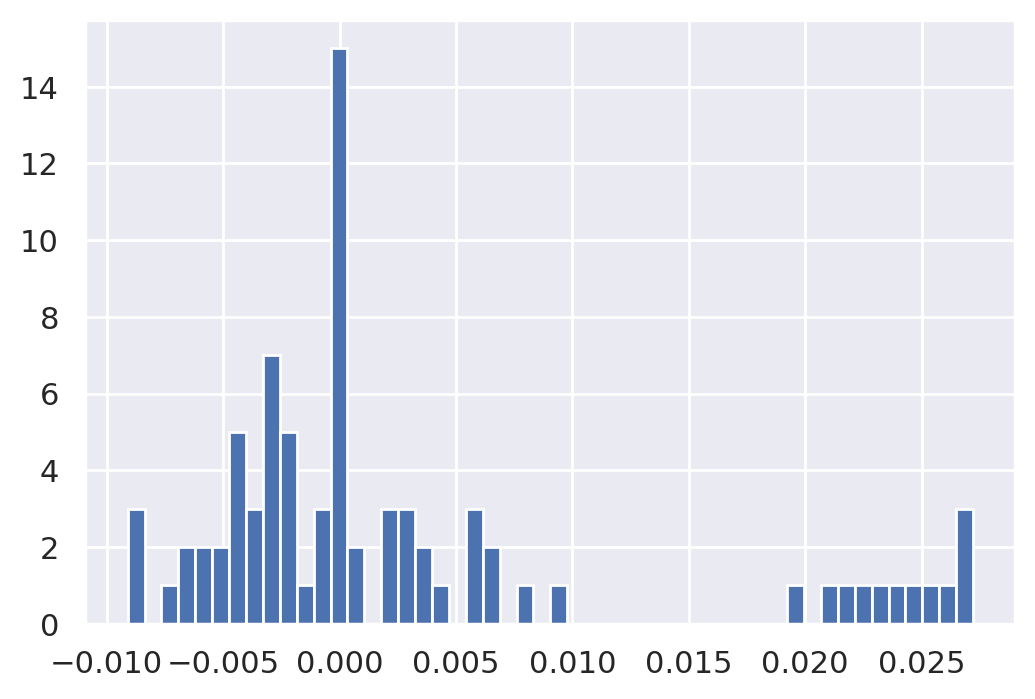

In [97]:
signed_dif = torch_scores - c_scores
plt.hist(signed_dif, bins=50)

In [126]:
#plt.plot(np.arange(79), signed_dif)